In [22]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install requests pandas sklearn matplotlib sktime

In [1]:
# covid data taken from open toronto dataset
input_covid_data = "./20201112-covid19-data.csv"
# provincial feature data pulled from the 2016 census
input_features_data = "./feature2.csv"

In [2]:
# general helpers
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
# regression functions
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
# load both datasets into pandas dataframes
covid_data = pd.read_csv(input_covid_data)
feature_data = pd.read_csv(input_features_data)

In [4]:
# filter out unwated rows and data before March 11th (since data before this data is sparse)
provincial_covid_data = covid_data[(covid_data['prname'] != 'Canada') & (covid_data['prname'] != 'Repatriated travellers')]
provincial_covid_data = provincial_covid_data[provincial_covid_data['date'] >= '2020-03-11']
# filter for the columns we will need
cols = ['date', 'prname', 'numtoday']
provincial_covid_data = provincial_covid_data[cols]

In [5]:
# separate covid data per province
ON_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Ontario']['numtoday'].reset_index(drop=True)
QC_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Quebec']['numtoday'].reset_index(drop=True)
AB_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Alberta']['numtoday'].reset_index(drop=True)
BC_covid = provincial_covid_data[provincial_covid_data['prname'] == 'British Columbia']['numtoday'].reset_index(drop=True)
NS_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Nova Scotia']['numtoday'].reset_index(drop=True)
YU_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Yukon']['numtoday'].reset_index(drop=True)
NW_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Northwest Territories']['numtoday'].reset_index(drop=True)
NV_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Nunavut']['numtoday'].reset_index(drop=True)
PEI_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Prince Edward Island']['numtoday'].reset_index(drop=True)
MB_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Manitoba']['numtoday'].reset_index(drop=True)
SS_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Saskatchewan']['numtoday'].reset_index(drop=True)
NL_covid = provincial_covid_data[provincial_covid_data['prname'] == 'Newfoundland and Labrador']['numtoday'].reset_index(drop=True)
NB_covid = provincial_covid_data[provincial_covid_data['prname'] == 'New Brunswick']['numtoday'].reset_index(drop=True)

In [8]:
# filter out unneeded columns
feature_data = feature_data[feature_data.columns.difference(['Avg_Age_Both', 'Avg_Age_M', 'Avg_Age_F', 'Med_Income'])]

In [9]:
# separate feature data per province
ON_features = feature_data[feature_data['Province_Name'] == 'Ontario']
QC_features = feature_data[feature_data['Province_Name'] == 'Quebec']
AB_features = feature_data[feature_data['Province_Name'] == 'Alberta']
BC_features = feature_data[feature_data['Province_Name'] == 'British Columbia']
NS_features = feature_data[feature_data['Province_Name'] == 'Nova Scotia']
YU_features = feature_data[feature_data['Province_Name'] == 'Yukon']
NW_features = feature_data[feature_data['Province_Name'] == 'Northwest Territories']
NV_features = feature_data[feature_data['Province_Name'] == 'Nunavut']
PEI_features = feature_data[feature_data['Province_Name'] == 'Prince Edward Island']
MB_features = feature_data[feature_data['Province_Name'] == 'Manitoba']
SS_features = feature_data[feature_data['Province_Name'] == 'Saskatchewan']
NL_features = feature_data[feature_data['Province_Name'] == 'Newfoundland and Labrador']
NB_features = feature_data[feature_data['Province_Name'] == 'New Brunswick']

In [10]:
def create_rolling_window(data, window_size=7):
    """ 
        Create a window from time A to B where each entry in the window is the
        number of new cases on that day.
    """
    data = data[data > 0] # remove days missing data
    ws = window_size + 1
    x_data = data[:-1]
    
    x_data = np.reshape(x_data, (-1,1))
    temp_data = np.roll(x_data, -1)
    for x in range(1, ws):
        # Stack
        x_data = np.concatenate((x_data[:-1], temp_data[:-1]), 1)
        # Step, roll left by 1
        temp_data = np.roll(temp_data, -1)[:-1]
    
    cols = ["day{}".format(i) for i in range(1,ws)] + ['newDay']
    return pd.DataFrame(x_data, columns=cols)

def split_train_test(data):
    """
        Divide into train,test,val sets
        Take first 70% as train and next 30% as test
    """
    ntrain,ntest = int(len(data) * 0.7), int(len(data) * 0.1)
    data = data.sample(frac=1)
    
    train = data[:ntrain].reset_index(drop=True)
    test = data[ntrain:].reset_index(drop=True)
    return train, test

def add_features(df,features):
    """ Append feature data to every row of df. """
    df['merger'] = 1
    features['merger'] = 1
    
    df = df.merge(features, how='outer', on='merger').drop(['merger','Province_Name'], axis=1)
    return df


In [11]:
def prepare_data(covid_df, features):
    """ Process of creating the final training and test sets from initial data. """
    rw = create_rolling_window(covid_df.values)
    rw_with_features = add_features(rw,features)
    
    return split_train_test(rw_with_features)

def split_xy(data):
    """ Separate training features and training output. """
    return data[data.columns.difference(['newDay'])], data['newDay']

In [12]:
ON_train, ON_test = prepare_data(ON_covid, ON_features)
QC_train, QC_test = prepare_data(QC_covid, QC_features)
AB_train, AB_test = prepare_data(AB_covid, AB_features)
BC_train, BC_test = prepare_data(BC_covid, BC_features)
NS_train, NS_test = prepare_data(NS_covid, NS_features)
YU_train, YU_test = prepare_data(YU_covid, YU_features)
NW_train, NW_test = prepare_data(NW_covid, NW_features)
NV_train, NV_test = prepare_data(NV_covid, NV_features)
PEI_train, PEI_test = prepare_data(PEI_covid, PEI_features)
MB_train, MB_test = prepare_data(MB_covid, MB_features)
SS_train, SS_test = prepare_data(SS_covid, SS_features)
NL_train, NL_test = prepare_data(NL_covid, NL_features)
NB_train, NB_test = prepare_data(NB_covid, NB_features)

<ipython-input-10-d277f22f6ac5>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['merger'] = 1


In [13]:
def model_with_RF(train_data,test_data):
    """ Model data using RandomForest Regressor. """
    x_train, y_train = split_xy(train_data)
    x_test, y_test = split_xy(test_data)
    
    model = RandomForestRegressor(n_estimators = 100, random_state = 0)
    model.fit(x_train,y_train)
    
    y_preds = model.predict(x_test)
    plt.plot(y_preds, label='preds')
    plt.plot(y_test, label='actual')
    plt.legend()
    
    print(np.mean(np.abs(y_preds-y_test))) # mean absolute error
    print(np.mean(np.power(y_preds-y_test,2))) # mean squared error

def model_with_LR(train_data,test_data):
    """ Model data using LinearRegressor. """
    x_train, y_train = split_xy(train_data)
    x_test, y_test = split_xy(test_data)
    
    model = LinearRegression()
    model.fit(x_train,y_train)
    
    y_preds = model.predict(x_test)
    plt.plot(y_preds, label='preds')
    plt.plot(y_test, label='actual')
    plt.legend()
    
    print(np.mean(np.abs(y_preds-y_test))) # mean absolute error
    print(np.mean(np.power(y_preds-y_test,2))) # mean squared error

In [39]:
def roll_days(df):
    """ Shift all case data one day to the left. """
    day = 'day{}'
    for i in range(1,7):
        df[day.format(i)] = df[day.format(i+1)]
        
    return df
        
def forecast(case_data, feature_data, days=7):
    """ Recursively predict the next 'days' by including the last prediction. """
    forecast_train_data = case_data[:-days]
    forecast_test_data = case_data[-days:].reset_index(drop=True)
    
    rw = create_rolling_window(forecast_train_data.values)
    rw_plus_features = add_features(rw,feature_data)
    forecast_start = rw_plus_features[-1:]
    X,Y = split_xy(rw_plus_features)
    
    model = LinearRegression()
    model.fit(X,Y)
    
    forecast_start = roll_days(forecast_start)
    forecast_start['day7'] = forecast_start['newDay']
    forecast_start, _ = split_xy(forecast_start) # drop the 'newDay' column

    dcols = ['day1','day2','day3','day4','day5','day6','day7',]
    predictions = []
    for i in range(days):
        predictions.append(round(model.predict(forecast_start)[0]))
        forecast_start = roll_days(forecast_start)
        forecast_start['day7'] = predictions[-1]
        
    print(predictions)
    print(forecast_test_data)
    print(np.mean(np.abs(predictions-forecast_test_data))) # mean absolute error
    print(np.mean(np.power(predictions-forecast_test_data,2))) # mean squared error
    
    plt.plot(predictions, label='preds')
    plt.plot(forecast_test_data, label='actual')
    plt.legend()

<ipython-input-29-d277f22f6ac5>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['merger'] = 1
<ipython-input-39-883795f901c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[day.format(i)] = df[day.format(i+1)]
<ipython-input-39-883795f901c8>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

[1003, 1005, 1004, 1031, 1016, 1018, 1033]
0     998
1    1003
2    1132
3    1328
4    1242
5    1388
6    1426
Name: numtoday, dtype: int64
203.0
63863.857142857145


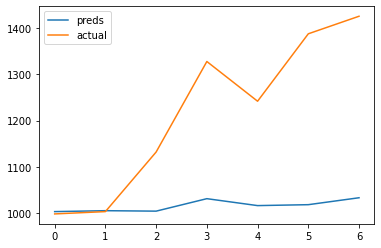

In [40]:
forecast(ON_covid, ON_features) # forecasting on last week of cases

<ipython-input-29-d277f22f6ac5>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['merger'] = 1
<ipython-input-37-2a006b8be869>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[day.format(i)] = df[day.format(i+1)]
<ipython-input-37-2a006b8be869>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

[913, 884, 840, 872, 899, 870, 865]
0     934
1     896
2    1015
3     977
4     948
5    1050
6     987
Name: numtoday, dtype: int64
94.85714285714286
13131.42857142857


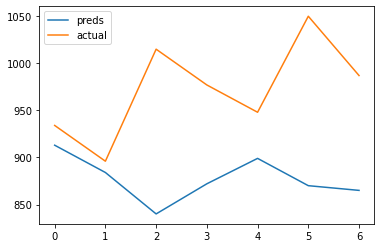

In [38]:
forecast(ON_covid, ON_features) # removed last week of cases (large spike in last week of data)

70.01814285714285
15561.829247142858


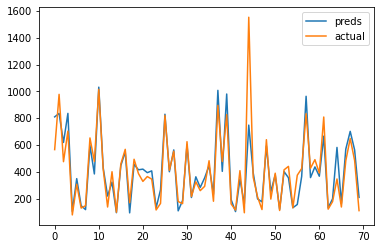

In [14]:
model_with_RF(ON_train,ON_test) # 70/30

61.73756474767413
14283.505998441049


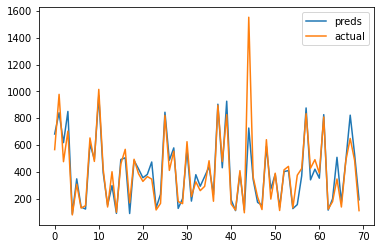

In [15]:
model_with_LR(ON_train,ON_test) #70/30

In [12]:
bigData = pd.concat([ON_train,QC_train,BC_train,AB_train], axis=0)
print(bigData)

     day1  day2  day3  day4  day5  day6  day7  newDay       Pop  Land_Area  \
0     370   387   412   399   477   346   294     308  13448494  908699.33   
1     121   138   154   112   118   170   116     130  13448494  908699.33   
2     379   550   483   478   411   401   421     483  13448494  908699.33   
3     135   203   165   103   195   138   137     119  13448494  908699.33   
4     375   408   309   379   550   483   478     411  13448494  908699.33   
..    ...   ...   ...   ...   ...   ...   ...     ...       ...        ...   
130   592   570   515   802   609   919   727     656   4067175  640330.46   
131   257    85   121    76    84   359     7      82   4067175  640330.46   
132   158   426   164   114   130   164   619      98   4067175  640330.46   
133    34    13    19    15     7    40    64      27   4067175  640330.46   
134    37    77   230    86    82   120   105     368   4067175  640330.46   

     Pop_Den  Avg_Age_Both  Avg_Age_M  Avg_Age_F  Avg_HS  \
0  

18.30865439211836
671.5894168599449


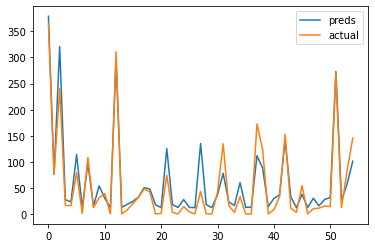

In [13]:
model_with_LR(bigData, MB_test)

66.18288987798526
9920.313296035898


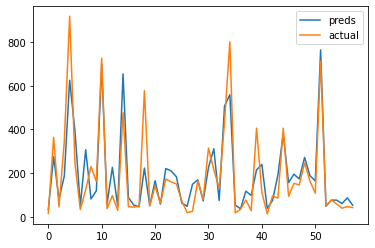

In [14]:
model_with_LR(bigData, AB_test)

69.24948381576259
8762.517386717805


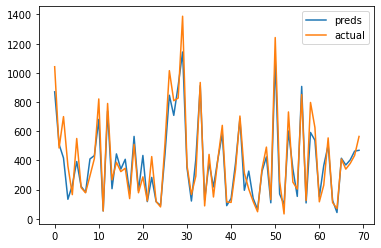

In [15]:
model_with_LR(CombinedData, ON_test)

70.07857142857142
8459.264682857143


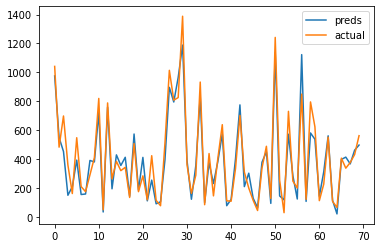

In [18]:
model_with_RF(CombinedData, ON_test)

In [24]:
ONdata = create_rolling_window(ON_covid.values)
BCdata = create_rolling_window(BC_covid.values)
onX,onY = ONdata[ONdata.columns.difference(['newDay'])], ONdata['newDay']
bcX,bcY = BCdata[BCdata.columns.difference(['newDay'])], BCdata['newDay']

54.77281430750186
9562.47003805177


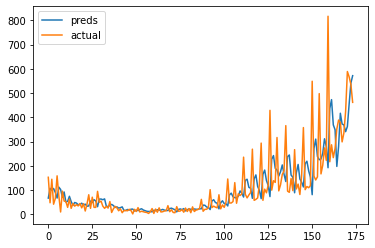

In [25]:
model = LinearRegression()
model.fit(onX,onY)
y_preds = model.predict(bcX)
print(np.mean(np.abs(y_preds-bcY))) # mean absolute error
print(np.mean(np.power(y_preds-bcY,2))) # mean squared error
plt.plot(y_preds, label='preds')
plt.plot(bcY, label='actual')
plt.legend()

82.01524188134309
23652.722599199613


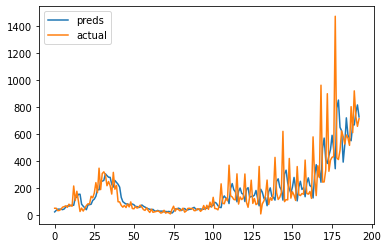

In [26]:
ABdata = create_rolling_window(AB_covid.values)
abX,abY = ABdata[BCdata.columns.difference(['newDay'])], ABdata['newDay']
y_preds = model.predict(abX)
print(np.mean(np.abs(y_preds-abY))) # mean absolute error
print(np.mean(np.power(y_preds-abY,2))) # mean squared error
plt.plot(y_preds, label='preds')
plt.plot(abY, label='actual')
plt.legend()